# Battery SoH Prediction using Linear Regression and Random Forest

## 1. Introduction
This notebook aims to estimate the **State of Health (SoH)** of cells using charge and discharge cycle data. Features were extracted from current, voltage, and duration metrics of different operation statuses (CC Chg, CC DChg, CCCV Chg, Rest).

## 2. Dataset
- Data comes from the **UCONN Battery Dataset**.  
- Each `CHECKUP.h5` file corresponds to a single cell and contains multiple cycles.  
- For each cycle, we computed metrics per status:
  - `avg_current`, `std_current`
  - `avg_voltage`, `std_voltage`
  - `duration`
- Each cycle has a **known real SoH**.  
- `cell_id` was included to ensure training and testing are done on **different cells**.

## 3. Data Preparation
- Cycle segmentation by **status change** (`State`).  
- Aggregation of features per status: mean, standard deviation, and duration.  
- Missing values were filled with `fillna(0)`.  
- Status values converted to numeric codes for analysis when needed.

## 5. Models
- 5.1 Linear Regression
- Trained using LinearRegression from scikit-learn.
- Evaluated using R² and MAE.

- 5.2 Random Forest
- Trained using RandomForestRegressor.
- Evaluated using R² and MAE.
- Feature importance computed to identify which metrics most influence SoH

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

def load_data(src):
    with h5py.File(src, "r") as f:
        keys = list(f.keys())
        raw = f[keys[0]][:]  

    # Convert to text
    text = raw.tobytes().decode("utf-8")

    # Load as json
    data_json = json.loads(text)

    df = pd.DataFrame(data_json)

    return df

def calculate_metrics(df):

    # Convert values to float
    df["time"] = df["time"].astype(float)
    df["voltage"] = df["voltage"].astype(float)
    df["current"] = df["current"].astype(float)

    # Identify changes in status to segment the data
    df.loc[:, "state_change"] = (df["State"] != df["State"].shift()).cumsum()

    # Group by status change segments
    grouped = df.groupby("state_change")

    results = []

    for _, g in grouped:
        subset = g.iloc[1:-1]

        if subset.empty or subset["State"].isna().all():
            continue

        status = subset["State"].iloc[0]
        start_time = subset["time"].iloc[0]
        end_time = subset["time"].iloc[-1]
        duration = end_time - start_time

        avg_current = subset["current"].mean()
        std_current = subset["current"].std()

        avg_tension = subset["voltage"].mean()
        std_tension = subset["voltage"].std()

        results.append({
            "status": status,
            "start_time": start_time,
            "end_time": end_time,
            "duration": duration,
            "avg_current": avg_current,
            "std_current": std_current,
            "avg_tension": avg_tension,
            "std_tension": std_tension
        })

    results = pd.DataFrame(results)

    return results

In [12]:
import os

src = "../../../../../../media/mods-pred/Datasets/Data_uconn_h5"
checkups_paths = []

for cell in sorted(os.listdir(src)):
    cell_path = os.path.join(src, cell)
    for file in sorted(os.listdir(cell_path)):
        if "CHECKUP" in file:
            checkups_paths.append(os.path.join(cell_path, file))

all_cycles = []

for checkup in checkups_paths:
    df = load_data(checkup)

    results = calculate_metrics(df)

    # Agregar features por tipo de status
    features = {}
    for status_name, group in results.groupby("status"):
        features[f"{status_name}_avg_current"] = group["avg_current"].mean()
        features[f"{status_name}_std_current"] = group["std_current"].mean()
        features[f"{status_name}_avg_tension"] = group["avg_tension"].mean()
        features[f"{status_name}_std_tension"] = group["std_tension"].mean()
        features[f"{status_name}_duration"] = group["duration"].sum()

    # SoH do ciclo
    features["SoH"] = max(df["capacity"].astype(float)) * 100 / 1.2
    features["cell_id"] = os.path.basename(os.path.dirname(checkup))
    all_cycles.append(features)

# Cria dataset final
dataset = pd.DataFrame(all_cycles).fillna(0)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

cells = dataset["cell_id"].unique()
train_cells, test_cells = train_test_split(cells, test_size=0.2, random_state=42)

train_df = dataset[dataset["cell_id"].isin(train_cells)]
test_df = dataset[dataset["cell_id"].isin(test_cells)]

X_train = train_df.drop(columns=["SoH", "cell_id"])
y_train = train_df["SoH"]
X_test = test_df.drop(columns=["SoH", "cell_id"])
y_test = test_df["SoH"]

# ------------------------
# Regressão Linear
# ------------------------
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

print("=== Regressão Linear ===")
print("R² teste:", r2_score(y_test, y_pred_lin))
print("MAE:", mean_absolute_error(y_test, y_pred_lin))
coef = pd.Series(lin_model.coef_, index=X_train.columns)
print("Features mais importantes (RL):")
print(coef.sort_values(key=abs, ascending=False))

# ------------------------
# Random Forest
# ------------------------
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest ===")
print("R² teste:", r2_score(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
print("Features mais importantes (RF):")
print(importances.sort_values(ascending=False))

=== Regressão Linear ===
R² teste: 0.7830398788439268
MAE: 1.6623382463203753
Features mais importantes (RL):
CCCV Chg_std_tension    3.749202e+02
CC DChg_std_tension     2.475745e+02
CC Chg_std_current      1.419663e+02
Rest_std_tension       -1.045206e+02
CC Chg_avg_current      8.556399e+01
CC Chg_std_tension     -5.983982e+01
CC DChg_avg_current     5.595715e+01
CC Chg_avg_tension     -3.368311e+01
CCCV Chg_std_current   -3.044045e+01
CC DChg_std_current    -2.618259e+01
CC DChg_avg_tension     6.692207e+00
Rest_avg_tension        2.127388e+00
CCCV Chg_avg_current   -5.722833e-01
CCCV Chg_avg_tension    5.353487e-01
Rest_duration          -8.763309e-03
CC Chg_duration         6.200394e-03
CCCV Chg_duration       4.256925e-03
CC DChg_duration        1.288787e-03
Rest_std_current       -3.765876e-13
Rest_avg_current       -9.148238e-14
dtype: float64

=== Random Forest ===
R² teste: 0.9516816608941996
MAE: 0.6887075188768507
Features mais importantes (RF):
CC DChg_duration        0.6

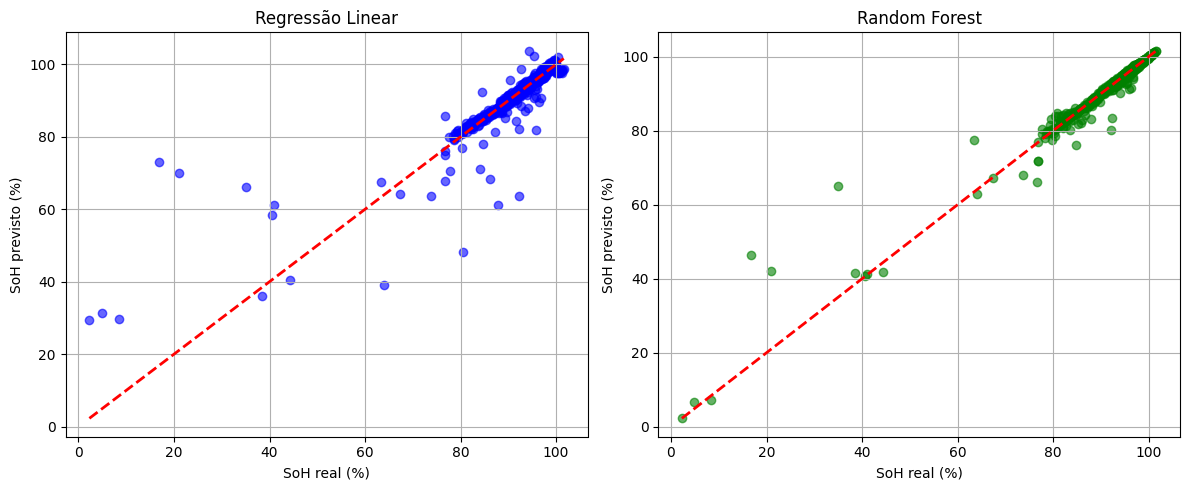

In [14]:
plt.figure(figsize=(12,5))

# RL
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Regressão Linear")
plt.grid(True)

# RF
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Random Forest")
plt.grid(True)

plt.tight_layout()
plt.show()


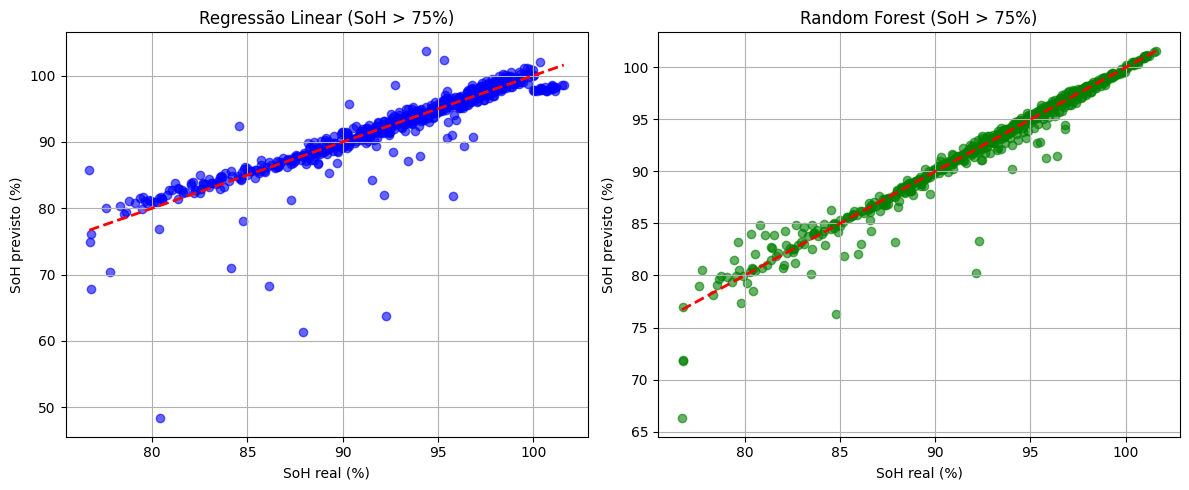

In [15]:
mask = y_test > 75
y_test_filtered = y_test[mask]
y_pred_lin_filtered = y_pred_lin[mask]
y_pred_rf_filtered = y_pred_rf[mask]

plt.figure(figsize=(12,5))

# RL
plt.subplot(1, 2, 1)
plt.scatter(y_test_filtered, y_pred_lin_filtered, color='blue', alpha=0.6)
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Regressão Linear (SoH > 75%)")
plt.grid(True)

# RF
plt.subplot(1, 2, 2)
plt.scatter(y_test_filtered, y_pred_rf_filtered, color='green', alpha=0.6)
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()], 'r--', lw=2)
plt.xlabel("SoH real (%)")
plt.ylabel("SoH previsto (%)")
plt.title("Random Forest (SoH > 75%)")
plt.grid(True)

plt.tight_layout()
plt.show()